In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
# from models import Net
# from preact_resnet import FP_PreActResNet34
# from T2_ResNetV2 import FP_T22ResNet36
from znd import ZNDOptimizer
from models import *

# nd_random
from random_noise.znd_random import ZNDRandom
# momentum_random
from random_noise.momentum_random import MomentumRandom
# adam_random
from random_noise.adam_random import AdamRandom

#nd_constant
from constant_noise.znd_constant import ZNDConstant
#momentum_constant
from constant_noise.momentum_constant import MomentumConstant
#adam_constant
from constant_noise.adam_constant import AdamConstant

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# net = Net()
# net = FP_T22ResNet36() # 6 epoch 34,002,920 0.014478657580912112
# net = FP_PreActResNet34() #8 epoch 0.015 34,172,904
net = resnet18()
# net = resnet34()
# net = inceptionv3()
# net = mobilenet()

net.to(device)
# print(net)
# model_name = 'FP_PreActResNet34.pt'
model_name = 'resnet18_SGD_C.pt'
I = 3
I = float(I)



In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform' 

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        images = images.to( device )

        # forward pass to get net output
        output_pts = net(images)
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
# print(test_images.data.size())
# print(test_outputs.data.size())
# print(gt_pts.size())

In [11]:
def show_all_keypoints(image, predicted_key_pts):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

def visualize_output(test_images, test_outputs, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20, 10))
        ax = plt.subplot(1, batch_size, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from it's Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        # transpose to go from torch to numpy image
        image = np.transpose(image, (1, 2, 0))

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(
            image), predicted_key_pts)

        plt.axis('off')

    plt.show()

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

# optimizer = optim.SGD(net.parameters(), lr = 0.001)
# optimizer1 = ZNDOptimizer(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4, I=I)
# optimizer1 = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=5e-4)

# optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=5e-4)
# optimizer = ZNDOptimizer(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4, I=I)
# optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=5e-4, momentum=0.9)

## constant noise
# optimizer = AdamConstant(net.parameters(),lr=0.001, betas=(0.9, 0.999), weight_decay=5e-4)
# optimizer = MomentumConstant(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# optimizer = ZNDConstant(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4, I = I)
## random noise
# optimizer = MomentumRandom(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# optimizer = ZNDRandom(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# optimizer = AdamRandom(net.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=5e-4)


In [13]:
def train_net_opt(n_epochs):
    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            images = images.to(device)
            key_pts = key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch_opt: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
    
    print('Finished Training')

In [152]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

In [153]:
train_net_opt(n_epochs)

Epoch_opt: 1, Batch: 10, Avg. Loss: 0.29531375169754026
Epoch_opt: 1, Batch: 20, Avg. Loss: 0.24545094072818757
Epoch_opt: 1, Batch: 30, Avg. Loss: 0.22671349495649337
Epoch_opt: 1, Batch: 40, Avg. Loss: 0.23424314260482787
Epoch_opt: 1, Batch: 50, Avg. Loss: 0.19756909608840942
Epoch_opt: 1, Batch: 60, Avg. Loss: 0.19269445091485976
Epoch_opt: 1, Batch: 70, Avg. Loss: 0.18178703635931015
Epoch_opt: 1, Batch: 80, Avg. Loss: 0.16624539941549302
Epoch_opt: 1, Batch: 90, Avg. Loss: 0.1762359470129013
Epoch_opt: 1, Batch: 100, Avg. Loss: 0.16376364827156067
Epoch_opt: 1, Batch: 110, Avg. Loss: 0.1423657529056072
Epoch_opt: 1, Batch: 120, Avg. Loss: 0.14913439080119134
Epoch_opt: 1, Batch: 130, Avg. Loss: 0.18024304658174514
Epoch_opt: 1, Batch: 140, Avg. Loss: 0.12659511342644691
Epoch_opt: 1, Batch: 150, Avg. Loss: 0.155691497027874
Epoch_opt: 1, Batch: 160, Avg. Loss: 0.14195484519004822
Epoch_opt: 1, Batch: 170, Avg. Loss: 0.1266352079808712
Epoch_opt: 1, Batch: 180, Avg. Loss: 0.129549

In [154]:
test_images, test_outputs, gt_pts = net_sample_output()

In [155]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [26]:
rs18_ND_R_model = resnet18()
rs18_ND_R_model.load_state_dict(torch.load( './saved_models/resnet18_ND_R.pt' ))
rs18_ND_R_model = rs18_ND_R_model.to(device)
rs18_SGDM_R_model = resnet18()
rs18_SGDM_R_model.load_state_dict(torch.load( './saved_models/resnet18_SGDM_R.pt' ))
rs18_SGDM_R_model = rs18_SGDM_R_model.to(device)

In [27]:
def show_keypoints(image, predicted_key_pts1, predicted_key_pts2):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts1[:, 0], predicted_key_pts1[:, 1], s=20, marker='.', c='m')
    plt.scatter(predicted_key_pts2[:, 0], predicted_key_pts2[:, 1], s=20, marker='.', c='g')

In [28]:
def compare_output(net1, net2):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        images = images.to( device )

        # forward pass to get net output
        output_pts1 = net1(images)
        output_pts2 = net2(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts1 = output_pts1.view(output_pts1.size()[0], 68, -1)
        output_pts2 = output_pts2.view(output_pts2.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts1, output_pts2, key_pts
test_images, test_outputs1, test_outputs2, gt_pts = compare_output( rs18_ND_R_model, rs18_ADAM_R_model )

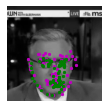

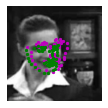

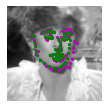

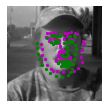

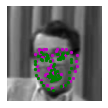

In [29]:
def visualize_compare(test_images,  test_outputs1, test_outputs2, gt_pts=None,  batch_size=10):
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts1 = test_outputs1[i].data
        predicted_key_pts1 = predicted_key_pts1.numpy()
        # undo normalization of keypoints  
        predicted_key_pts1 = predicted_key_pts1*50.0+100

        predicted_key_pts2 = test_outputs2[i].data
        predicted_key_pts2 = predicted_key_pts2.numpy()
        # undo normalization of keypoints  
        predicted_key_pts2 = predicted_key_pts2*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_keypoints(np.squeeze(image), predicted_key_pts1, predicted_key_pts2)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_compare(test_images.cpu(), test_outputs1.cpu(), test_outputs2.cpu(), gt_pts)

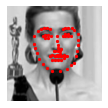

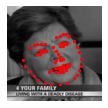

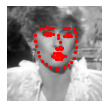

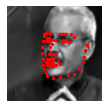

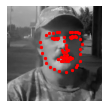

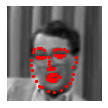

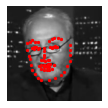

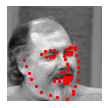

In [30]:
def show_all_keypoints_ground_truth(image, gt_pts):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='r')


def visualize_ground_truth(test_images, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20, 10))
        ax = plt.subplot(1, batch_size, i + 1)
        image = test_images[i].data  # get the image from it's Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        # transpose to go from torch to numpy image
        image = np.transpose(image, (1, 2, 0))

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints_ground_truth(np.squeeze(
            image), ground_truth_pts)

        plt.axis('off')

    plt.show()
visualize_ground_truth(test_images.cpu(), gt_pts)